<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="Descrição da imagem" style="width: 1000px; height: auto; ">


<div style=" padding: 10px; font-size: 45px; text-align: center;">
<strong>  Oh no, I´m falling in dropout again 📉: </strong> 
<div style=" padding: 10px; font-size: 36px; text-align: center;">
<strong>Implementação de Dropout em uma MLP feita em Python puro</strong> 

<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Autores:</strong> Júlia Guedes A. dos Santos & Maria Emily Nayla Gomes da Silva 
<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Professor:</strong> Daniel R. Cassar

<div style="background-color: lightblue; font-size: 18px; padding: 10px;">
<div style="text-align: justify"><strong>Objetivo:</strong> implemente o regularizador dropout na rede neural feita em Python puro. </div>

## **Introdução**  📝

<div style="text-align:justify">
Um dos principais desafios enfrentados durante o treinamento de uma rede neural é o <em>Overfitting</em> (do português sobreajuste), no qual o modelo se ajusta demasiadamente aos dados de treino e, consequentemente, apresenta desempenho reduzido na previsão de dados desconhecidos. Nesse contexto, como uma das principais estratégias para mitigar esse problema surge o <strong>Dropout</strong>, o qual, diferentemente de estratégias de regularização convencionais - que atuam na modificação da função de custo -, alterama própria estrutura da rede. Isso ocorre por meio da desativação aleatória (e temporária) de neurônios presentes nas camadas ocultas, sendo que a quantidade de unidades desativadas dependerá de um limiar estabelecido (Ex: se esse valor for igual a 0.2, 20 % da quantidade total de neurônios será desativada a cada iteração de treinamento). [1][2]

Para melhor compreensão desse conceito, nesse notebook, iremos implementar a estratégia de Dropout em uma rede Multilayer Perceptron construída em Python puro [3]. Como forma de validar a implementação realizada, o dataset "Breast Cancer Classification" será utilizado. Os dados consistem na descrição de tumores cancerígenos para a classificação em benigno ou maligno (coluna ``diagnosis``). Vale ressaltar que o dataset possui 32 colunas, no entanto, para diminuir o tempo de treinamento da rede, usaremos apenas as seguintes colunas: 
</div>


| Features    | Descrição                                                                                      |
|-----------|-----------------------------------------------------------------------------------------------|
| `radius_mean`   | Raio dos lóbulos das mamas                                                |
| `texture_mean`  | Média da textura da superfície                                                     |
| `perimeter_mean`  | Perímetro externo do lóbulo               |
| `area_mean`  | Área média do lóbulo              |
| `smoothness_mean`  | Média da suavidade dos contornos              |
| `compactness_mean`  | Média da compacidade               |
| `concavity_mean`  | Média da concavidade (profundidade das regiões côncavas dos contornos)               |
| `concavity_points`  | Média da quantidade de pontos de concavidade nos contornos               |


## **Importação das bibliotecas & Dataset** 📚

Em primeiro lugar, precisamos importar as bibliotecas necessárias para a resolução do problema.

In [1]:
# Importação e manipulação do dataset
import zipfile
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Definição da rede neural
import math 
import random
import numpy as np

# Cálculo de métrica
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot de gráficos 
import matplotlib.pyplot as plt

# Outras bibliotecas
from sklearn.dummy import DummyClassifier

Após isso, é possível, por meio do suporte da plataforma Kaggle para terminal, baixar o dataset que será utilizado. 

In [2]:
# !kaggle datasets download -d yasserh/breast-cancer-dataset

In [3]:
# with zipfile.ZipFile("breast-cancer-dataset.zip", "r") as zip_ref:
#     zip_ref.extractall("breast-cancer-dataset")
# os.listdir("breast-cancer-dataset")

A partir disso, conseguimos visualizar o dataset.

In [4]:
df = pd.read_csv("breast-cancer.csv").dropna()
display(df)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Para definir o target, precisamos transformar o target em uma variável numérica. Para isso, iremos representar os tumores **malignos** por 1 e os **benignos** por 0.

In [5]:
for i in range(len(df["diagnosis"])):
    if df["diagnosis"][i] == "M":
         df.loc[i, "diagnosis"] = 1
    else:
        df.loc[i, "diagnosis"] = 0

Após isso, considerando que as colunas definidas na introdução, é possível separar os dados em três conjunto: treino, validação e teste.

In [6]:
# Split treino e teste
TAMANHO_TESTE = 0.1

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=10185, shuffle=True
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

# Split treino e validação
indices = df_treino.index
indices_treino, indices_validacao= train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=10185, shuffle=True
)

df_treino = df.loc[indices_treino]
df_validacao = df.loc[indices_validacao]


In [7]:
features_utilizadas = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean']

In [8]:
X_treino      = df_treino.loc[:, features_utilizadas].values  
y_treino = df_treino["diagnosis"].values.reshape(-1, 1)

X_validacao = df_validacao.loc[:, features_utilizadas].values
y_validacao = df_validacao["diagnosis"].values.reshape(-1, 1)

X_teste       = df_teste.loc[:, features_utilizadas].values  
y_teste = df_teste["diagnosis"].values.reshape(-1, 1)

Finalmente, como última etapa de pré processamento, podemos normalizar os dados, utilizando o normalizador padrão do módulo Scikit-Learn. 

In [9]:
normalizador_X = StandardScaler()
X_treino = normalizador_X.fit_transform(X_treino)
X_validacao = normalizador_X.transform(X_validacao)
X_teste = normalizador_X.transform(X_teste)

## **Treinamento da MLP**  🏋🏻‍♀️

Como próxima etapa, precisamos definir as classes necessárias para a composição da MLP, as quais são: ```Valor```, ```Neuronio```, ```Camada``` e ```MLP```. Vale ressaltar que para a implementação do dropout, as duas últimas precisarão ser modificadas. 

##### **Classe Valor**

In [10]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data 
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado

    def log(self): 
        """Realiza a operação log(self)"""
        progenitor = (self, )
        if self.data <= 10**(-15):
            self.data = 10**(-15)
        data = math.log(self.data)
        operador_mae = "log"
        resultado = Valor(data, progenitor, operador_mae)

        def propagar_log():
            self.grad += resultado.grad * (1 / data)

        resultado.propagar = propagar_log

        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):                          
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

##### **Classe Neurônio**

In [11]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        #print(num_dados_entrada)
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        #print(len(x), print(len(self.pesos)))
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()  
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

##### **Classe Camada**

In [12]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada, dropout_p = 0, camada_visivel = 0):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios
        self.dropout_p = dropout_p
        self.camada_visivel = camada_visivel
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            if self.camada_visivel == 1 and random.random() < self.dropout_p:
                informacao = Valor(0)
            else:
                informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

##### **Classe MLP**

In [13]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada, dropout_p = 0):
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        camadas = []
 
        self.dropout_p = dropout_p #######
        # camada_entrada = Camada(num_neuronios_por_camada[0], percurso[0], self.dropout_p, 1) 
        # camadas.append(camada_entrada)
 
        tamanho = len(num_neuronios_por_camada)
        for i in range(tamanho):
            if i == 0 or i == tamanho-1:
                camada = Camada(num_neuronios_por_camada[i], percurso[i], self.dropout_p)
            else:
                camada = Camada(num_neuronios_por_camada[i], percurso[i], self.dropout_p, 1)
            camadas.append(camada)
        # camada_final = Camada(num_neuronios_por_camada[-1], percurso[-2], self.dropout_p, 1) 
        # camadas.append(camada_final)
        self.camadas = camadas

    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    def parametros(self):
        params = []
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
        return params

A principal modificação está na classe ``Camada``, onde foi inserida uma estrutura condicional que realiza um sorteio probabilístico para cada neurônio (um número entre 0 e 1), determinando se ele será desativado ou não: caso essa probabilidade seja maior do que o valor do hiperparâmetro P, o neurônio continuará a computação de forward pass, caso contrário, o valor da saída será definido como 0.  Já na classe ``MLP``, optamos por não aplicar Dropout nas camadas de entrada e saída, pois desejamos utilizar todas as informações disponíveis na entrada e obter todas as saídas da rede. Esse comportamento é controlado pelo argumento camada_visivel no método de inicialização da classe ``Camada``, cujo valor padrão é 0, indicando que a camada é oculta.


##### **Arquitetura da rede e padrões de treinamento**

Com as classes definidas, é possível estabelecer a estrutura de rede neural. Considerando a baixa otimização do código de MLP utilizado, apenas uma camada será definida, com 20 neurônios. Em relação ao dropout, esse será definido como 0.05 (ou seja, apenas 5% dos neurõnios serão desligados).

In [14]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [64, 32]
P = 0.05


arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]
mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede, P)

Vale ressaltar que, por se tratar de uma rede classificatória binária, a função para o cálculo da perda será a cross_entropy, definida pela função abaixo:

$$
Loss = - \frac{1}{N} \sum_{i = 1}^{N} y_i \cdot \ln(p(y_i)) + (1 - y_i) \cdot \ln(1 - p(y_i))
$$

<p style="text-align:center">
[Fórmula 1: Binary Cross Entropy]
</p>

In [15]:
def bin_cross_entropy(y_true, y_pred):

    soma = 0
    for yt, yp in zip(y_true, y_pred):
        elemento_somatorio = yt * yp.log() + (Valor(1) - yt) * (Valor(1) - yp).log()
        soma += elemento_somatorio
    
    loss = - soma / len(y_true)
    
    return loss

Finalmente, podemos estabelecer o ciclo de treinamento da rede neural, o qual será composto por 500 épocas e com uma taxa de aprendizado de $10^{-3}$. 

In [16]:
y_treino = [y for y in df_treino["diagnosis"]]

In [17]:
NUM_EPOCAS = 100
TAXA_DE_APRENDIZADO = 0.001

resultado_loss_treino = []
resultado_loss_validacao = []

for epoca in range(NUM_EPOCAS): 
    
    y_pred_treino = []
    y_pred_validacao = []
    
    for exemplo in X_treino:
        previsao = mlp(exemplo)
        y_pred_treino.append(previsao)
        
    for exemplo in X_validacao:
        previsao = mlp(exemplo)
        y_pred_validacao.append(previsao)
        

    erros_treino  = []
    erros_validacao = [] 
              
    loss_treino = bin_cross_entropy(y_treino, y_pred_treino)
                  
    resultado_loss_treino.append(loss_treino.data)
    
    for p in mlp.parametros():
        p.grad = 0

    loss_treino.propagar_tudo()

    for p in mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO
        
    
    loss_validacao = bin_cross_entropy(y_validacao, y_pred_validacao)
    #print(loss_validacao.item().data[0], loss_validacao)

    resultado_loss_validacao.append(loss_validacao.item().data[0])

    
    print(f"O erro da época {epoca} é igual a: {loss_treino.data} (treino) e {loss_validacao.item().data[0]} (validação)")

O erro da época 0 é igual a: 1.012456098059493 (treino) e 0.9391334183804715 (validação)
O erro da época 1 é igual a: 0.9676534865189466 (treino) e 0.9028246014668163 (validação)
O erro da época 2 é igual a: 1.0092773278648495 (treino) e 0.8911527505688862 (validação)
O erro da época 3 é igual a: 1.001608203517594 (treino) e 0.9051196755266278 (validação)
O erro da época 4 é igual a: 0.9874691229321161 (treino) e 0.920342379923563 (validação)
O erro da época 5 é igual a: 1.0073134657036398 (treino) e 0.9357899063415536 (validação)
O erro da época 6 é igual a: 1.0010847780318672 (treino) e 0.9003772759453613 (validação)
O erro da época 7 é igual a: 0.9908613450877232 (treino) e 0.9527148367581637 (validação)
O erro da época 8 é igual a: 0.998580239139704 (treino) e 0.8657061804829965 (validação)
O erro da época 9 é igual a: 0.9920594674136829 (treino) e 0.8841392885363208 (validação)
O erro da época 10 é igual a: 0.9740788558833222 (treino) e 0.9206252282404505 (validação)
O erro da épo

## **Análise de resultados** 📊

A partir das listas "resultado_loss_treino" e "resultado_loss_validacao", podemos avaliar os resultados por meio do plot de uma curva de aprendizado. 

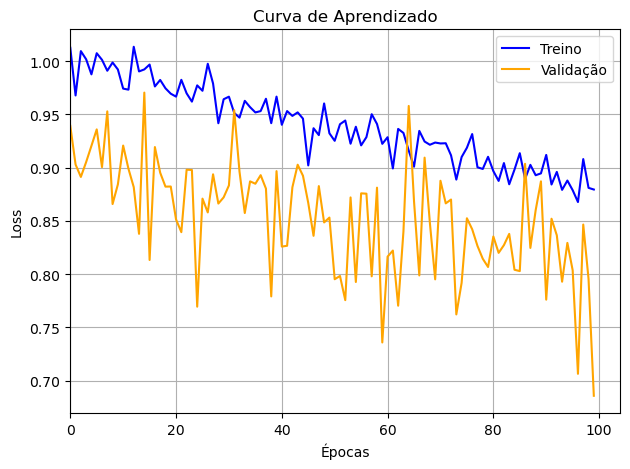

In [18]:
X_plot = list(range(0, 100, 1))

plt.plot(X_plot, resultado_loss_treino, label="Treino", color="blue")
plt.plot(X_plot, resultado_loss_validacao, label="Validação", color="orange")

plt.title("Curva de Aprendizado")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xlim(0)

plt.tight_layout()
plt.show()

Temos um resultado inesperado! A curva de aprendizado não apresenta um comportamento contínuo, apresentando diversas oscilações durante o período de treinamento. Apesar disso, é possível observar que tanto a curva de treinamento quanto a de validação apresentam tendência de queda, o que pode significar que, apesar de não ser o comportamento esperado, a rede conseguiu capturar, de certa forma, o padrão dos dados. Além disso, os dados de validação apresentam erro menor do que os de treino, o que pode significar que a implementação do dropout foi bem-sucedida.
 
Agora, para testar o desempenho, podemos usar o conjunto de teste para calcular a acurácia e plotar a matriz de confusão.

In [19]:
y_pred = []
for exemplo in X_teste:
    previsao = mlp(exemplo)
    y_pred.append(previsao.data)

In [21]:
y_true = ["M" if i > 0.5 else "B" for i in y_teste]
y_pred = ["M" if i > 0.5 else "B" for i in y_pred]

Acurácia = 64.91%


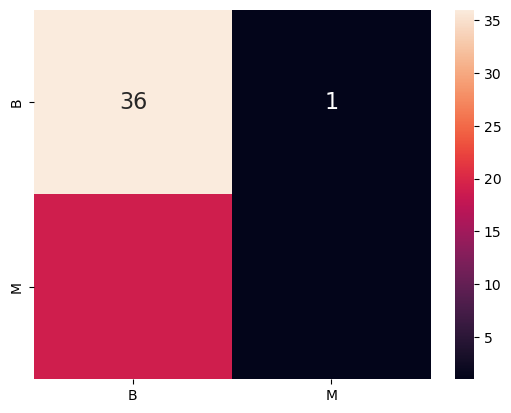

In [22]:
acuracia = accuracy_score(y_true, y_pred)

print(f"Acurácia = {(acuracia*100):.2f}%")

ordem_labels = ["B", "M"]

matriz_conf = confusion_matrix(y_true, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16});

Ao final, temos que a acurácia de 54.39%, sendo que, pela matriz de confusão, é possível perceber que a rede apresenta maior probabilidade de prever que o tumor é maligno (rótulo M). 

In [23]:
dummy_model = DummyClassifier()
modelo = dummy_model.fit(X_treino, y_treino)

In [24]:
y_pred_dummy = modelo.predict(X_teste)
y_pred_dummy = ["M" if i > 0.5 else "B" for i in y_pred_dummy]

In [25]:
acuracia_dummy = accuracy_score(y_pred=y_pred_dummy, y_true=y_true)
print(y_pred_dummy)

print(f"Acurácia do modelo Dummy = {(acuracia_dummy*100):.2f}%")

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
Acurácia do modelo Dummy = 64.91%


Ambos apresentaram a mesma acurácia!

## **Conclusão** 😁

Ao final, como esperado a partir da implementação do regularizador Dropout, os dados de validação apresentaram melhor desempenho em comparação aos dados de treino. No entanto, a acurácia encontrada para a rede treinada foi igual a de um modelo Dummy, o que pode significar que a estrutura não foi complexa o suficiente para encontrar parâmetros robustos que pudessem capturar a complexidade dos dados. Portanto, tem-se que apesar da implementação bem-sucedida do dropout, foi possível concluir que essa estratégia não foi eficaz para o dados utilizados no notebook.

## **Referências!** 🗃️ 

[1] DropOut Layer. NumPyNet. Disponível em: <https://nico-curti.github.io/NumPyNet/NumPyNet/layers/dropout_layer.html>. Acesso em: 19 abr. 2025.

[2] DSA, Equipe. Capítulo 23 - Como Funciona o Dropout? Deep Learning Book. Disponível em: <https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/>. Acesso em: 19 abr. 2025.

[3] Referência Principal (construção da rede neural em Python puro): Andrej Karpathy. The spelled-out intro to neural networks and backpropagation: building micrograd (2022). https://www.youtube.com/watch?v=VMj-3S1tku0
